# Analyzing the ClimEx Large Ensemble

[ClimEx](https://www.climex-project.org/) is a project investigating the influence of climate change on hydro-meteorological extremes. To understand the effect of natural variability on the occurrence of rare extreme events, ClimEx ran 50 independent simulations, increasing the sample size available.

Analyzing simulation outputs from large ensembles can get tedious due to the large number of individual netCDF files to handle. To simplify data access, we've created an aggregated view of daily precipitation and temperature for all 50 ClimEx realizations from 1955 to 2100.

The first step is to open the dataset, whose path can be found in the `climex` catalog. Although there are currently 36 250 individual netCDF files, there is only one link in the catalog.

In [1]:
import shutil

import intake
import xarray as xr
import xclim
from clisops.core.subset import subset_gridpoint
from dask.diagnostics import ProgressBar
from dask.distributed import Client, LocalCluster
from IPython.display import HTML, Markdown
from xclim import ensembles as xens

# fmt: off
climex = "https://pavics.ouranos.ca/catalog/climex.json"  # TEST_USE_PROD_DATA
# fmt: on

cat = intake.open_esm_datastore(climex)
cat.df.head()

/home/tjs/mambaforge/envs/pavics-sdi/lib/python3.9/site-packages/xclim/ensembles/_reduce.py:26: UserWarning: Matplotlib installed. Setting make_graph to True.
  warn("Matplotlib installed. Setting make_graph to True.")


,license_type,title,institution,driving_model_id,driving_experiment,type,processing,project_id,frequency,modeling_realm,variable_name,variable_long_name,path
0,permissive non-commercial,The ClimEx CRCM5 Large Ensemble,Ouranos Consortium on Regional Climatology and...,CCCma-CanESM2,"historical, rcp85",RCM,raw,CLIMEX,day,atmos,"['rotated_pole', 'tasmin', 'tasmax', 'tas', 'p...","['NA', 'Daily Minimum Near-Surface Temperature...",https://pavics.ouranos.ca/twitcher/ows/proxy/t...


In [2]:
# Opening the link takes a while, because the server creates an aggregated view of 435,000 individual files.
url = cat.df.path[0]
ds = xr.open_dataset(url, chunks=dict(realization=2, time=30 * 3))
ds

<xarray.Dataset>
Dimensions:       (rlat: 280, rlon: 280, time: 52924, realization: 50)
Coordinates:
  * rlat          (rlat) float64 -12.61 -12.51 -12.39 ... 17.85 17.96 18.07
  * rlon          (rlon) float64 2.695 2.805 2.915 3.025 ... 33.17 33.28 33.39
  * time          (time) object 1955-01-01 00:00:00 ... 2099-12-30 00:00:00
  * realization   (realization) |S64 b'historical-r1-r10i1p1' ... b'historica...
    lat           (rlat, rlon) float32 dask.array<chunksize=(280, 280), meta=np.ndarray>
    lon           (rlat, rlon) float32 dask.array<chunksize=(280, 280), meta=np.ndarray>
Data variables:
    rotated_pole  (time) |S64 dask.array<chunksize=(90,), meta=np.ndarray>
    tasmin        (realization, time, rlat, rlon) float32 dask.array<chunksize=(2, 90, 280, 280), meta=np.ndarray>
    tasmax        (realization, time, rlat, rlon) float32 dask.array<chunksize=(2, 90, 280, 280), meta=np.ndarray>
    tas           (realization, time, rlat, rlon) float32 dask.array<chunksize=(2, 90, 280, 280), meta=np.ndarray>
    pr            (realization, time, rlat, rlon) float32 dask.array<chunksize=(2, 90, 280, 280), meta=np.ndarray>
    prsn          (realization, time, rlat, rlon) float32 dask.array<chunksize=(2, 90, 280, 280), meta=np.ndarray>
Attributes: (12/29)
    Conventions:           CF-1.6 
    DODS.dimName:          string1
    DODS.strlen:           1
    EXTRA_DIMENSION.bnds:  2
    NCO:                   "4.5.2"
    abstract:              The ClimEx CRCM5 Large Ensemble of high-resolution...
    ...                    ...
    product:               output 
    project_id:            CLIMEX
    rcm_version_id:        v3331 
    terms_of_use:          http://www.climex-project.org/sites/default/files/...
    title:                 The ClimEx CRCM5 Large Ensemble
    type:                  RCM

The CLIMEX dataset currently stores 5 daily variables, simulated by CRCM5 driven by CanESM2 using the representative concentration pathway RCP8.5:
- `pr`: mean daily precipitation flux
- `prsn`: mean daily snowfall flux
- `tas`: mean daily temperature
- `tasmin`: minimum daily temperature
- `tasmax`: maximum daily temperature

There variables are stored along spatial dimensions (rotated latitude and longitude), time (1955-2100) and realizations (50 members). These members are created by first running five members from CanESM2 from 1850 to 1950, then small perturbations are applied in 1950 to spawn 10 members from each original member, to yield a total of 50 global realizations. Each realization is then dynamically downscaled to 12 km resolution over Québec.

<div>
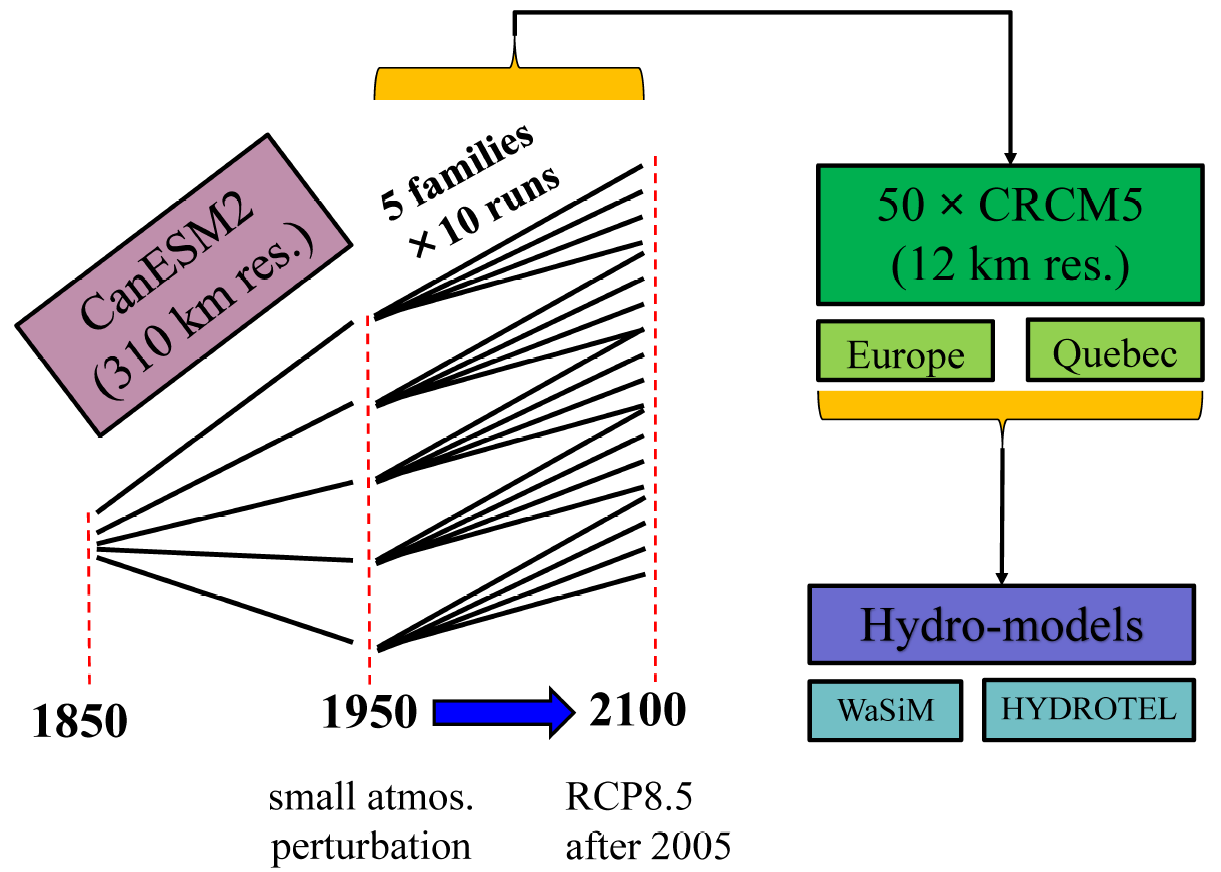
</div>


In [3]:
ds.realization[:5].data.tolist()

[b'historical-r1-r10i1p1',
 b'historical-r1-r1i1p1',
 b'historical-r1-r2i1p1',
 b'historical-r1-r3i1p1',
 b'historical-r1-r4i1p1']

# Creating maps of ClimEx fields

The data is on a rotated pole grid, and the actual geographic latitudes and longitudes of grid centroids are stored in the variables with the same name. We can plot the data directly using the native `rlat` and `rlon` coordinates easily.

[########################################] | 100% Completed | 1.52 sms


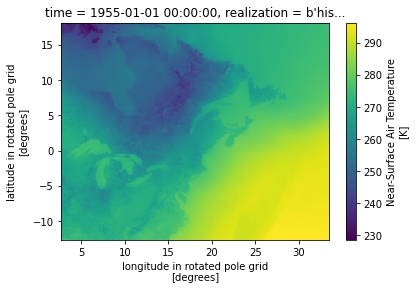

In [4]:
# NBVAL_IGNORE_OUTPUT
from matplotlib import pyplot as plt

with ProgressBar():
    field = ds.tas.isel(time=0, realization=0).load()
    field.plot()

However, the axes are defined with respect to the rotated coordinates. To create a map with correct geographic coordinates, we could use the real longitudes and latitudes (`plt.pcolormesh(ds.lon, ds.lat, field)`), but a better option is to create axes with the same projection used by the model. That is, we set the map projection to `RotatedPole`, using the coordinate reference system defined in the `rotated_pole` variable. We can use a similar approach to project the model output on another projection.

/home/tjs/mambaforge/envs/pavics-sdi/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/home/tjs/mambaforge/envs/pavics-sdi/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/home/tjs/mambaforge/envs/pavics-sdi/lib/python3.9/sit

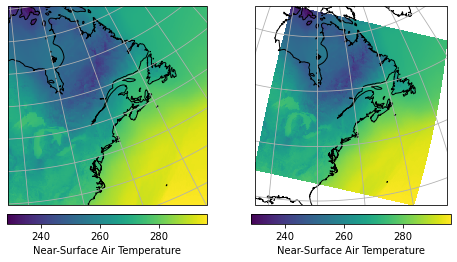

In [5]:
# NBVAL_IGNORE_OUTPUT
import cartopy.crs as ccrs

with ProgressBar():
    # The CRS for the rotated pole (data)
    rotp = ccrs.RotatedPole(
        pole_longitude=ds.rotated_pole.grid_north_pole_longitude,
        pole_latitude=ds.rotated_pole.grid_north_pole_latitude,
    )

    # The CRS for your map projection (can be anything)
    ortho = ccrs.Orthographic(central_longitude=-80, central_latitude=45)

    fig = plt.figure(figsize=(8, 4))

    # Plot data on the rotated pole projection directly
    ax = plt.subplot(1, 2, 1, projection=rotp)
    ax.coastlines()
    ax.gridlines()
    m = ax.pcolormesh(ds.rlon, ds.rlat, field)
    plt.colorbar(
        m, orientation="horizontal", label=field.long_name, fraction=0.046, pad=0.04
    )

    # Plot data on another projection, transforming it using the rotp crs.
    ax = plt.subplot(1, 2, 2, projection=ortho)
    ax.coastlines()
    ax.gridlines()
    m = ax.pcolormesh(
        ds.rlon, ds.rlat, field, transform=rotp
    )  # Note the transform parameter
    plt.colorbar(
        m, orientation="horizontal", label=field.long_name, fraction=0.046, pad=0.04
    )

    plt.show()

# Computing climate indicators

Next we'll compute a climate indicator as an example. We'll compute the mean precipitation intensity for 50 members for the year 2000, then compute ensemble statistics between realizations. The amount of data that we'll be requesting is however too big to go over the network in one request. To work around this, we need to first chunk the data in smaller `dask.array` portions by setting the `chunks` parameter when creating our dataset.

* When selecting `xarray` chunk sizes it is important to consider both the "on-disk" chunk sizes of the netcdf data as well as the type of calculation you are performing.  For example the Climex data variables `_ChunkSizes` attributes indicate on-disk chunk size for dims `time, rlat, rlon` of `[365  50  50]`<a href="#footnote-1"><sup>**1**</sup></a>.  Using multiples of these values is a reasonable way to ensure that in-memory `dask` chunks line up with the way that the data is stored on disk.  

* The next step is to think about the calculation we wish to perform. In this case we wish to analyse a single year of data for all realizations over the entire spatial domain. Using something like `chunks = dict(realization=1, time=365, rlat=50*3, rlon=50*3)` seems reasonable as a start. The general goal is to find a balance between chunk-size and a number of chunks ... too many small chunks to process will create a lot of overhead and slow the calculation down.  Very large chunks will use a lot of system memory causing other issues or data timeouts from the PAVICS thredds server.  In this specific case having a large `time` chunk could result in reading more data than necessary seeing as we are only interested in a single year.

* Enabling chunking also has the effect of making further computations on these chunks *lazy*. The next cell is thus going to execute almost instantly, because no data is transferred, and no computation executed. Calculations are launched when the data is actually needed, as when plotting graphics, saving to file, or when requested explicitly by calling the compute, persist or load methods. Below we make use of a dask.distributed Client of worker processes to parallelize computations and improve performance.

<p id="footnote-1" ><font size="1"><sup>1</sup>  In this case the `realization` chunk size is not included in the netcdf file attributes as this is a virtual dimension resulting from the NcML aggregation.</font></p>

In [7]:
# This will return instantaneously, because xclim is using lazy evaluation whenever possible.

sdii = xclim.atmos.daily_pr_intensity(
    ds.pr.isel(realization=[4, 5], rlat=slice(100, 200), rlon=slice(100, 200)).sel(
        time="2020"
    ),
    freq="YS",
)

In [8]:
# NBVAL_IGNORE_OUTPUT
# This will trigger the computation. Be patient, this will take some time.\n",

with ProgressBar():
    out = sdii.load()

[########################################] | 100% Completed | 90.92 ss


Text(0.5, 1.0, 'Ensemble mean')

/home/tjs/mambaforge/envs/pavics-sdi/lib/python3.9/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


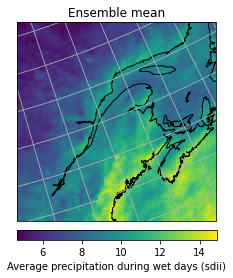

In [9]:
fig = plt.figure(figsize=(8, 4))

ax = plt.subplot(1, 1, 1, projection=rotp)
ax.coastlines()
ax.gridlines()
m = ax.pcolormesh(
    out.rlon, out.rlat, out.mean(dim="realization").isel(time=0), shading="auto"
)
plt.colorbar(
    m, orientation="horizontal", label=sdii.long_name, fraction=0.046, pad=0.04
)
ax.set_title("Ensemble mean")

As you can see, execution is fairly slow, and we believe this is due to the THREDDS server limitations. We're investigating solutions to speed this type of calculations. The access time issue is especially problematic with time series analysis. In the next example, we extract one grid point over Montréal and then extract the time series. The data extraction cell is commented out because it takes around 6 minutes to complete.

In [10]:
ds = xr.open_dataset(
    url, chunks=dict(realization=1, time=365, rlat=50 * 3, rlon=50 * 3)
)
xclim.set_options(check_missing="pct", missing_options={"pct": {"tolerance": 0.05}})
sdii = xclim.atmos.daily_pr_intensity(pr=ds.pr.sel(time="2000"))
sdii

<xarray.DataArray 'sdii' (realization: 50, time: 1, rlat: 280, rlon: 280)>
dask.array<where, shape=(50, 1, 280, 280), dtype=float64, chunksize=(1, 1, 150, 150), chunktype=numpy.ndarray>
Coordinates:
  * rlat         (rlat) float64 -12.61 -12.51 -12.39 ... 17.85 17.96 18.07
  * rlon         (rlon) float64 2.695 2.805 2.915 3.025 ... 33.17 33.28 33.39
  * realization  (realization) |S64 b'historical-r1-r10i1p1' ... b'historical...
    lat          (rlat, rlon) float32 dask.array<chunksize=(150, 150), meta=np.ndarray>
    lon          (rlat, rlon) float32 dask.array<chunksize=(150, 150), meta=np.ndarray>
  * time         (time) object 2000-01-01 00:00:00
Attributes:
    units:          mm/day
    cell_methods:   time: mean
    history:        [2022-11-22 16:14:50] sdii: SDII(pr=pr, thresh='1 mm/day'...
    standard_name:  lwe_thickness_of_precipitation_amount
    long_name:      Average precipitation during wet days (sdii)
    description:    Annual simple daily intensity index (sdii) : annual avera...

In [12]:
# Create a local client with 6 workers processes.
dask_kwargs = dict(
    n_workers=6,
    threads_per_worker=6,
    memory_limit="4GB",
    local_directory="/notebook_dir/writable-workspace/tmp",
)

with Client(**dask_kwargs) as client:
    # Client(**dask_kwargs) as client:
    display(
        HTML(
            f'<div class="alert alert-info"> Consult the client <a href="{client.dashboard_link}" target="_blank"><strong><em><u>Dashboard</u></em></strong></a> or the <strong><em>Dask jupyter sidebar</em></strong> to follow progress ... </div>'
        )
    )
    out = xens.ensemble_mean_std_max_min(sdii.to_dataset())
    out = out.load()

/home/tjs/mambaforge/envs/pavics-sdi/lib/python3.9/site-packages/distributed/node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43551 instead
  warnings.warn(


PermissionError: [Errno 13] Permission denied: '/notebook_dir'

In [13]:
fig = plt.figure(figsize=(15, 5))
for ii, vv in enumerate([v for v in out.data_vars if "stdev" not in v]):

    ax = plt.subplot(1, 3, ii + 1, projection=rotp)
    ax.coastlines()
    ax.gridlines()
    m = ax.pcolormesh(
        out.rlon, out.rlat, out[vv].isel(time=0), vmin=0, vmax=30, cmap="YlGnBu"
    )
    plt.colorbar(
        m, orientation="horizontal", label=out[vv].long_name, fraction=0.046, pad=0.04
    )
    ax.set_title(f"Ensemble {vv.split('_')[-1]}")

AttributeError: 'DataArray' object has no attribute 'data_vars'

<Figure size 1080x360 with 0 Axes>

In the next example, we extract one grid point over Montréal in order to calculate the annual maximum 1-day precipitation for all years and ensemble members. In this case we would likely benefit by rethinking out chunk sizes.  
* Since we are only interested in a single grid-cell there is no real need to have relatively large spatial chunks in the `rlon` and `rlat` dimensions read into memory to simply be immediately discarded. In this case we reduce the spatial chunk size. 
* Similarly, since we are only looking at a single point we can likely get away with loading all time steps into a single chunk.

In [ ]:
# Subset over the Montreal gridpoint
ds = xr.open_dataset(url, chunks=dict(realization=1, time=-1, rlon=10, rlat=10))
pt = subset_gridpoint(ds, lon=-73.69, lat=45.50)
print("Input dataset for Montreal :")
display(pt)
out = xclim.atmos.max_1day_precipitation_amount(pr=pt.pr, freq="YS")
print("Maximim 1-day precipitation `lazy` output ..")
out

In [ ]:
# Compute the annual max 1-day precipitation
dask_kwargs = dict(
    n_workers=6,
    threads_per_worker=6,
    memory_limit="4GB",
    local_directory="/notebook_dir/writable-workspace/tmp",
)
with Client(**dask_kwargs) as client:
    # dashboard available at client.dashboard_link
    display(
        HTML(
            f'<div class="alert alert-info"> Consult the client <a href="{client.dashboard_link}" target="_blank"><strong><em><u>Dashboard</u></em></strong></a> or the <strong><em>Dask jupyter sidebar</em></strong> to follow progress ... </div>'
        )
    )
    out = out.load()

In [ ]:
out_ens = xens.ensemble_mean_std_max_min(out.to_dataset())
fig = plt.figure(figsize=(15, 7))
ax = plt.subplot(1, 1, 1)
h1 = out.plot.line(ax=ax, x="time", color="b", linestyle=":", alpha=0.075, label=None)
h2 = plt.fill_between(
    x=out_ens.time.values,
    y1=out_ens.rx1day_max,
    y2=out_ens.rx1day_min,
    color="b",
    alpha=0.3,
    label="ensemble min - max",
)
h3 = plt.plot(
    out_ens.time.values, out_ens.rx1day_mean, color="b", label="ensemble mean"
)
handles, labels = ax.get_legend_handles_labels()
leg = ax.legend(handles[::-1], labels[::-1])
tit = plt.title(
    f"ClimEx large ensemble \n Montreal : {out.description} {out_ens.time.dt.year[0].values} to {out_ens.time.dt.year[-1].values}"
)